## Qual o problema? 
- Implementação dos algoritmos genéticos para o reconhecimento de padrões.
- O objetivo é reconhecer o 0, sendo identificado pela bitstring [1 1 1 1 0 1 1 0 1 1 1 1].

### Qual o problema ? 
- Possuímos a seguinte equação matemática
![title](image/equacao.png)
- Quanto maior o resultado dessa função, melhor para nós.
- Queremos descobrir qual valor de **X**  gera um resultado maior? 
- Não temos a resposta exata, ou seja, na teoria não sabemos o quanto essa função pode ser maximizada, portanto quanto maior o valor que conseguimos melhor.

### Representação 
- O domínio do problema se dá em um intervalo de [0, 1]
- X pode assumir qualquer valor dentro desse domínio

### Objetivo
- **Maximizar** o resultado da equação através do maior valor possível de X.
- O melhor valor será definido por aquele que tiver o maior resultado final dentre todas as soluções encontradas

## Codificando
- Vamos começar com a importação das bibliotecas usadas.

In [3]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Criação da função de custo / avaliação
- É o coração dos algoritmos de otimização
- A função de custo é onde a avaliação do algoritmo vai acontecer de fato
- Nesse caso a função de custo é dada simplesmente pelo resultado da equação que deve ser maximizado

In [4]:
def funcao_custo(x):
    if isinstance(x, tuple):
        x = x[0]

    custo = 2 ** (-2 *((((x-0.1) / 0.9)) ** 2)) * ((math.sin(5*math.pi*x)) ** 6)
    return custo

### Exibindo os resultados
- A função de plotar busca gera um gráfico simples que mostra a variação dos resultados da função de custo x número de iterações do algoritmo
- A função de exibir sumário por outro lado nos exibe na tela o sumário de resultados do algoritmo.
- Lembrando que os resultados do algoritmo podem ser no sentido de maximização ou minimização de um valor, por isso um dos parâmetros dessa função é a escolha desse objetivo

In [5]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(t, resultados)
    plt.show()

In [6]:
def exibir_sumario_resultados(solucao, custos, objetivo = max):
    print('Valor que gerou melhor resultado:', solucao[custos.index(objetivo(custos))])
    print('Melhor custo:', objetivo(custos))
    print('Média de custos:', np.mean(custos))
    print('Desvio padrão:', np.std(custos))
    plotar_busca(custos)

### Pegando os vizinhos
- A função **get_vizinhos** é usada para pegar os vizinhos de cada dimensão da minha variável, no nosso caso temos uma única dimensão, que é o valor da variável X.
- Sendo assim vamos pegar os dois vizinhos possíveis do nosso X, sendo o valor superior e inferior ao X atual, configurando assim os movimentos que ele poderá fazer pelo espaço de busca em cada iteração. 
- O vizinho nada mais é que uma **perturbação** no valor inicial, pode se um valor constante ou alguma outra formula, como a gaussiana.
- Nesse caso, optei por usar uma constante para gerar a perturbação. A constante conseguiu explorar bem o espaço de busca, porém a sua grandeza foi escolhida baseada nos testes de desempenho de cada algoritmo.
- Na nossa função de get_vizinhos, nós temos também um parâmetro não obrigatório de taxa de aprendizado, que pode ser usado para reduzir o valor da constante baseado nas iterações do algoritmo, fazendo com que os passos dados na nossa busca sejam menores conforme as iterações.
- Isso faz com que nosso passo seja maior a princípio, fazendo com que a exploração pelo espaço de busca comece de forma mais rápida, porém ele desacelera com o passar do tempo, diminuindo o risco de pularmos nosso máximo global por estar com um "passo" muito grande.
- Por fim nós também adicionamos operadores condicionais para garantir que nossos vizinhos sejam pontos menores que 1 e maiores que 0 (dentro do domínio)

In [7]:
def get_vizinhos(solucao, tx_aprendizado = 1):
    vizinhos = []
    constante = 0.005 / tx_aprendizado
    vizinho_superior = solucao + constante if solucao + constante < 1 else solucao
    vizinho_inferior = solucao - constante if solucao - constante > 0 else solucao
    
    vizinhos.append(vizinho_superior)
    vizinhos.append(vizinho_inferior)
    return vizinhos

### Pegando valor aleatório espaçado
- A função de **get_valor_aleatório** vai garantir que meus valores aleatórios tenham um espaço mínimo entre eles.
- Essa função é usada porque os algoritmos, principalmente o Hill Climbing, dependem de sua inicialização, pois iniciar em um ponto favorável pode gerar resultados consideravelmente melhores do que em um ponto não favorável.
- Com isso, damos maior capacidade de exploração no espaço de busca para algoritmos que são mais fortes na explotação, através de multiplas inicializações.
- Esse espaço mínimo foi definida por uma constante, sua grandeza deve ser de acordo com o tamanho do domínio do problema.

In [8]:
def get_valor_aleatorio(espaco, x=0):
    inicio = random.random()
    valor = []
    
    for i in espaco:
        diferenca = i - inicio
        if diferenca > 0.08 or diferenca < -0.08:
            valor.append(diferenca)

    if len(valor) == len(espaco) or x > 300:
        return inicio
    else:
        return get_valor_aleatorio(espaco, x = x + 1)

### Hill Climbing
- Função que vai fazer o cálculo do algoritmo de subida da encosta
- Os critérios de parada são:
    - Atingir 400 iterações
    - Ficar 20 iterações sem melhoria
    - Ter apenas vizinhos piores que a solução atual
- A ideia de parada no platô é valida caso nosso algoritmo fique preso em uma armadilha de "maximo local reto" como podemos ver na imagem, fazendo com que o algoritmo não tenha que ser executado pelo limite de 400 iterações.
- Claro que o parâmetro de platô também não pode ser muito pequeno, pois caso tenhamos caído em um "ombro (shoulder)" existe a esperança de melhoria
    
![title](image/hill-climbing.png)

- Não foi usado uma semente aleatória para não remover a propriedáde estocástica do algoritmo, principalmente pelo fato que foram realizadas diversas execuções

In [9]:
def hill_climbing(funcao_custo, solucao_inicial, tx_aprendizado = 1):
    solucao = solucao_inicial
    custos = []
    count = 0
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao, tx_aprendizado)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo >= melhor:
                parar_no_plato = parar_no_plato + 1 if custo == melhor else 0
                melhor = custo
                solucao = vizinhos[i]

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            if parar_no_plato == 20: print('parada no platô')
            break

    return solucao, custos

## Execução e avaliação do Hill Climbing
- Possuímos aqui diversas formas de se inicializar e executar o algoritmo de subida da encosta para tentar buscar melhores resultados.
- Porém, não é interessante que a gente execute ele apenas uma vez, pois ele tem uma variação muito grande nos resultados, por depender muito da inicialização.
- Para tal, estou executando o algoritmo 30 vezes
- A função executar hill climbing possui parâmetros que vai modificar a forma como o hill climbing vai se comportar na busca por melhores soluções

In [10]:
def executar_hill_climbing(funcao_custo, iteracoes, espaco_minimo = False, get_melhor_resultado = False):
    custos = []
    solucao = []
    espaco_solucao = []
    
    for i in range(iteracoes):
        espaco_solucao.append(get_valor_aleatorio(espaco_solucao))
        valor_inicial = random.random() if espaco_minimo == False else espaco_solucao[len(espaco_solucao) - 1]   
        solucao_subida_encosta = hill_climbing(funcao_custo, valor_inicial) if get_melhor_resultado == False else hill_climbing(funcao_custo, solucao[custos.index(max(custos))] if len(custos) > 0 else random.random(), i + 1)
        solucao.append(solucao_subida_encosta[0])
        custos.append(max(solucao_subida_encosta[1]))
        custo_individual = solucao_subida_encosta[1]
        
    return solucao, custos, custo_individual

### Inicialização aleatória
- Nessa primeira forma o algoritmo foi inicializado com um valor aleatório dentro do nosso domínio [0,1] pelas 30 iterações.

In [11]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30)

Valor que gerou melhor resultado: 0.10004427648546108
Melhor custo: 0.9999985455125151
Média de custos: 0.6739240824255415
Desvio padrão: 0.24017887656975664


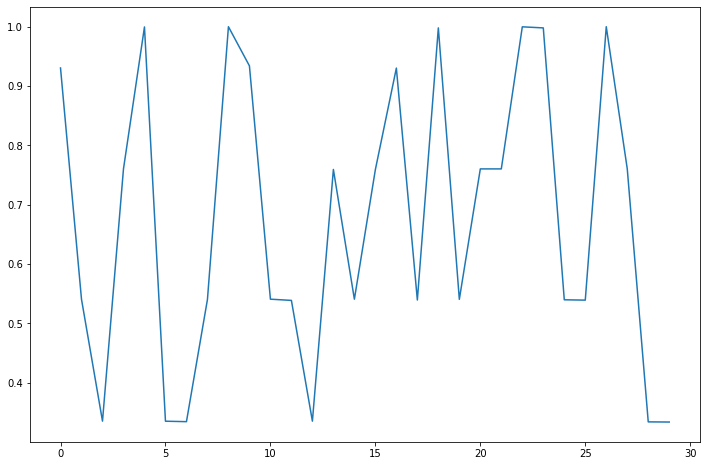

In [12]:
exibir_sumario_resultados(solucao, custos)
#O gráfico é a variação do custo máximo em cada iteração

- Como podemos ver, conseguimos atingir o valor X de 0.1, chegando a um custo de 0.99.
- Porém fica claro no gráfico a enorme variáção dos resultados cada vez que o algoritmo é inicializado
- Isso se reflete obviamente nas médias e desvio padrão das 30 execuções, gerando um algoritmo bastante instável.

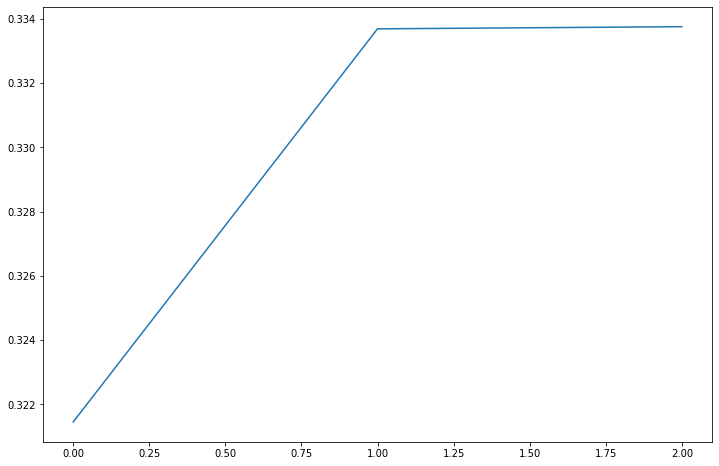

In [13]:
plotar_busca(grafico_subida_encosta)

- Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de subida da encosta é sempre fazer esse movimento linear positivo, pois ele sempre tenta melhorar seus resultados, na pior das hipóteses teremos uma linha reta constante.

### Explorando o espaço de busca
- Usamos nossa função de pegar o valor aleatório para garantir um espaçamento entre os valores randômicos iniciais, aumentando a exploração do espaço de busca.

In [14]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True)

Valor que gerou melhor resultado: 0.1007806094156229
Melhor custo: 0.9995479939509079
Média de custos: 0.6978590142304022
Desvio padrão: 0.24310035674049327


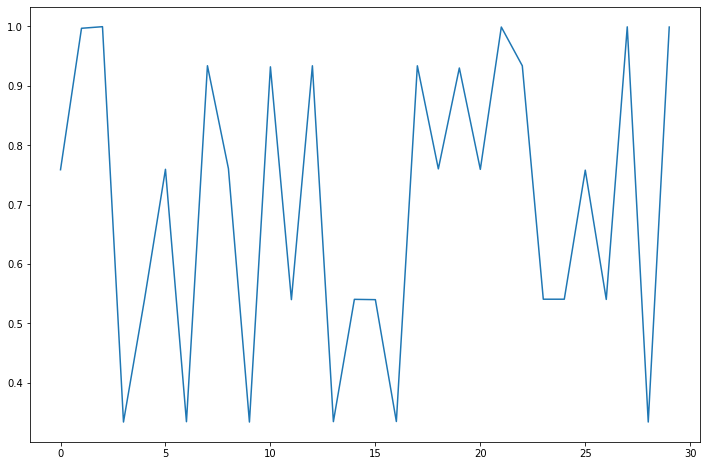

In [15]:
exibir_sumario_resultados(solucao, custos)

- Como pudemos ver os resultados não mudaram muito em relação à versão anterior, possivelmente se tivéssemos um espaço de busca maior do que [0,1] essa abordagem seria mais impactante para os resultados

### Limitando o espaço de busca
- A ideia aqui é iniciar o algoritmo não de forma aleatória, mas baseado nos resultados obtidos anteriormente, fazendo com que nosso foco esteja nos melhores resultados.
- Claro que apenas iniciar com o melhor valor da execução anterior sem modificar a forma como obtemos os vizinhos não seria bom, pois a execução anterior foi interrompida pela falta de melhoria.
- Portanto, utilizamos aqui a "taxa de aprendizado", fazendo com que o valor da nossa constante fique menor em cada iteração

In [16]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True, True)

Valor que gerou melhor resultado: 0.4989967341107382
Melhor custo: 0.7609336683831217
Média de custos: 0.7608495616359047
Desvio padrão: 0.00021822774054031907


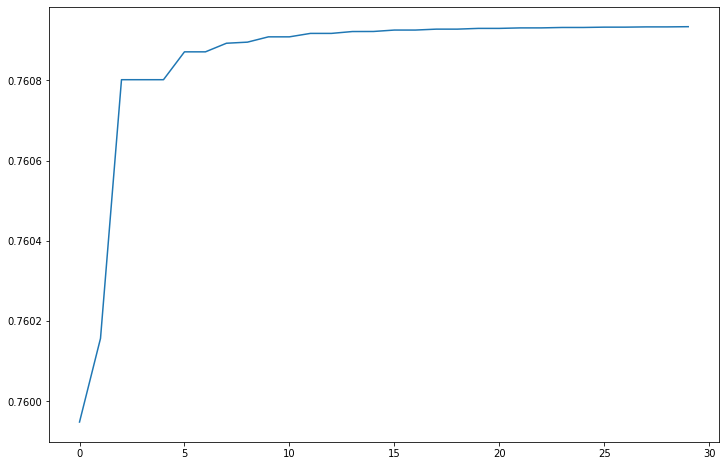

In [17]:
exibir_sumario_resultados(solucao, custos)

- Dessa forma, o algoritmo voltou a ser completamente dependente da sua inicialização, mesmo que executado diversas vezes, se o ponto inicial é desfavorável então ele todo se sai mal.
- Todavia ele gera alguns resultados com essa execução em sequência, pois da passos cada vez menores rumo ao possível máximo global, gerando chances maiores de atingir o ponto global caso estejamos na "montanha" correta.
- Caso tenhamos um problema com mais dimensões, essa abordagem pode ser ainda mais benéfica, pois leva em consideração o espaço de busca onde os valores estão se saindo bem, apesar de claro, pode se limitar bastante aos locais.

### Simulated annealing
Recozimento simulado é inspirado em um fenômeno da física, onde se esquenta um metal ou vidro até quase ele se liquefazer e depois se esfria devagar, para que os átomos percam a vibração aos poucos e o material fique rígido

- A diferença dele para o Hill Climbing é que ele tem uma probabilidade P de aceitar valores negativos
- Quanto mais no início do algoritmo, maior a sua chance de aceitar um valor negativo

### Probabilidade
- A probabilidade do simulated annealing é dada pela função exponencial exp(x)
- Nessa função, elevamos o número de euler ~2.7 à um valor de x.
- O X no nosso caso é o resultado da subtração entre o novo custo e o custo anterior divido pela temperatura: (x' - x) / T
- A temperatura vai diminuindo gradativamente, limitando nossas interações e garantindo que a probabilidade de se aceitar valores negativos também diminua

### Problemas encontrados na abordagem
- Foi encontrado um problema relacionado ao valor da temperatura, que precisa ser normalizado, pois nesse caso estamos trabalhando com valores muito pequenos e uma temperatura sem ser normalizada gera probabilidades sempre próximos a 100%, fazendo com que valores negativos sejam sempre aceitos

In [18]:
def get_iteracoes(temperatura, resfriamento):
    count = 0
    while temperatura > 0.1:
        temperatura = temperatura * resfriamento
        count += 1
    return count

In [19]:
def simulated_annealing(funcao_custo, temperatura = 100.0, resfriamento = 0.95, passo = 1):
    iteracoes = get_iteracoes(temperatura, resfriamento)
    probabilidade = 100
    queda_prob = probabilidade / iteracoes
    solucao = random.random()
    custos = []
    parar_no_plato = 0

    while temperatura > 0.1:
        vizinhos = get_vizinhos(solucao)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            
            if parar_no_plato == 20:
                break

            custo = funcao_custo(vizinhos[i])
            #probabilidade = pow(math.e, (custo - melhor) / temperatura) 
            probabilidade = probabilidade - queda_prob 
            
            if custo >= melhor or random.random() < probabilidade:
                parar_no_plato = parar_no_plato + 1 if solucao_atual == solucao else 0
                melhor = custo
                solucao = vizinhos[i]
               
        temperatura = temperatura * resfriamento

    return solucao, custos

In [20]:
custos = []
solucao = []

for i in range(30):
    solucao_tempera_simulada = simulated_annealing(funcao_custo)
    solucao.append(solucao_tempera_simulada[0])
    custos.append(max(solucao_tempera_simulada[1]))
    custo_individual = solucao_tempera_simulada[1]

Valor que gerou melhor resultado: 0.09989253120510544
Melhor custo: 0.9999914310602065
Média de custos: 0.915039142155531
Desvio padrão: 0.13200232489582908


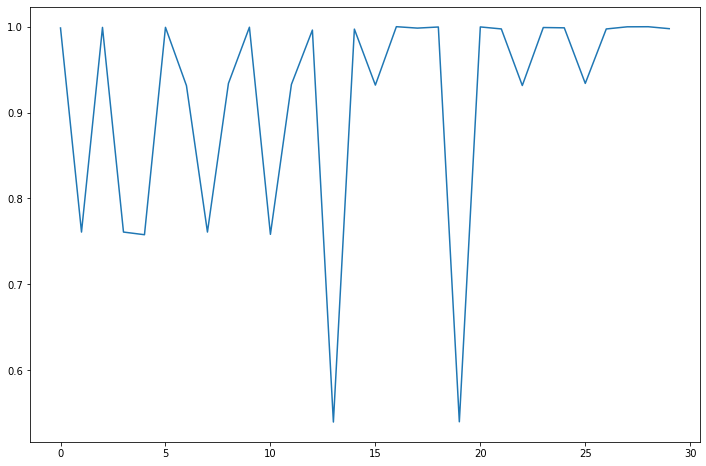

In [21]:
exibir_sumario_resultados(solucao, custos)

- Nosso algoritmo de recozimento simulado resultou em uma abordagem consideravelmente mais estável, apesar de ter atingido resultados muito semelhantes ao subida da encosta ele consegue atingir os mesmo resultados ótimos ao longo da maioria das iterações, sendo este fato refletido na média alta e no baixo desvio padrão.

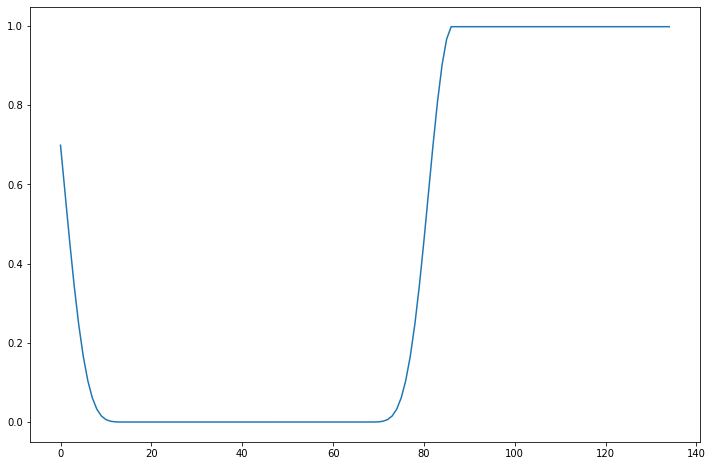

In [22]:
plotar_busca(custo_individual)

- Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de recozimento sumilado é fazer algumas "curvas", devido a variação de valores negativos e positivos, é possível que ele termine em um "plato", pois ele chega a um ponto na temperatura onde a probabilidade de aceitar valores negativos é muito baixa.

## Algoritmo genético
- Minha implementação de algoritmo genético foi um pouco diferente da abordagem vista em aula.
- Primeiramente eu optei, nesse problema em específico, por usar a representação puramente numérica ao invés de converter os valores para bits.
- Com isso, os operadores genéticos foram feitos de forma a respeitar esse padrão
- Nos exemplos vistos em aula, temos uma array (cromossomo) composto pelos genes (cada posição no array), sendo representado dessa forma: [1,0,1,1,0].
- No meu caso, a ideia é representa cada **INDIVÍDUO** da população como uma possível solução, onde cada dimensão é um gene e o conjunto de dimensões e meu cromossomo.
- Sendo assim nesse problema eu tenho que meu X é meu gene e também meu cromossomo (pois é um problema de apenas 1 dimensão)

### Mutação
- Processo aleatório que ocorre na população, mudando as características de um gene.
- Nesse meu caso, onde meu cromossomo e gene são resumidos a apenas um valor (X), minha mutação se deu através da aplicação de um valor aleatório dentro do domínio.
- Esse valor aleatório tem 50% de chance de ser uma somatória e 50% de ser uma subtração
- Portanto, minha função de mutação aplica uma subtração ou divisão aleatória no meu gene.

In [23]:
def mutacao(solucao):
    constante = 0.05
    mutante = []

    for i in range(len(solucao)):
        if random.random() < 0.5:
            if ((solucao[i] - constante) >= -5):
                mutante.append(solucao[i] - constante)
            else:
                mutante.append(solucao[i]) 
        else:
            if ((solucao[i] + constante) <= 5):
                mutante.append(solucao[i] - constante)
            else:
                mutante.append(solucao[i]) 

    return tuple(mutante)

### crossover 
- Técnica onde os indivíduos da população compartilham os genes, distribuindo as características entre eles.
- Em problemas multidimensionais faz sentido compartilhar as características dos nossos indivíduos pais através da troca aleatorizada de genes.
- Todavia nesse caso, meu crossover se resumia a gerar um "filho" a partir de dois genes numéricos e para isso fiz basicamente uma média dos valores.
- A média então é considerada o filho resultante

In [24]:
def crossover(solucao1, solucao2):
    crossed = [(solucao1[i] + solucao2[i]) / 2 for i in range(len(solucao1))]
    return tuple(crossed)

### Torneio
- O torneio é a forma escolhida apriori para seleção dos melhores indivíduos da população.
- Nesse método uma nova população é gerada.
- A diversidade da população deve variar baseado na quantidade de "competidores" por vez no torneio, a princípio escolhi 3 competidores aleatórios por vez para formar a nova população, isso da uma boa chance de escolher um valor que talvez não seja dos melhores, mas garante uma boa diversidade também.
- O tamanho da nova população que será reproduzida (de forma sexuada ou não) é dada pela metade do tamanho da população, subtraída claro do número de elitismo, que são os indivíduos que serão conservados para próxima geração.

In [25]:
def get_populacao_torneio(populacao, numero_elitismo, objetivo, n_competidores = 3):
        nova_populacao = []
        while len(nova_populacao) < numero_elitismo:
            torneio = []

            for i in range(n_competidores):
                torneio.append(populacao[random.randint(0, len(populacao) - 1)])
            
            torneio.sort(reverse=objetivo)
            nova_populacao.append(torneio[0][1])
        
        return nova_populacao

### Elitismo
- O elitismo é uma abstração que não ocorre na natureza mas podemos tirar proveitos no ambiente artificial do nosso algoritmo.
- Aqui, nós escolhemos os melhores indivíduos da nossa população (baseado na nossa função de aptidão) e passamos esses indivíduos para próxima geração, fazendo com que eles sejam conservados em seu estado natural.

In [26]:
def get_melhores_individuos(custos, n_elitismo, objetivo):
    custos.sort(reverse=objetivo)
    individuos_ordenados = [individuos for (custo, individuos) in custos]
    elite = individuos_ordenados[0:n_elitismo]
    return elite

### Geração da população
- O método gerar_população, como o próprio nome sugere, tem a missão de criar a nossa população inicial de indivíduos.
- Essa população possui um número N de indivíduos escolhidos pelo usuário, porém seus valores são aleatórios dentro do domínio.

In [27]:
def get_populacao(tamanho_populacao, dominio, numeros_inteiros = False):
    populacao = []
    for i in range(tamanho_populacao):
        if numeros_inteiros == False:
            solucao = [random.uniform(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        else:
            solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        
        populacao.append(tuple(solucao)) 
        
    return populacao

In [50]:
def genetico(funcao_custo, dominio, objetivo = False, tamanho_populacao = 50, p_mutacao = 0.2, 
             elitismo = 0.1, geracoes=20):
    
    populacao = get_populacao(tamanho_populacao, dominio)
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao - numero_elitismo) // 2, objetivo)
    
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(mutacao(individuos_escolhidos[individuo_selecionado]))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(crossover(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
    return custos[0][0], custos[0][1]

Valor que gerou melhor resultado: (0.10000000004103878,)
Melhor custo: 1.0
Média de custos: 0.9901576974311221
Desvio padrão: 0.022683431957404996


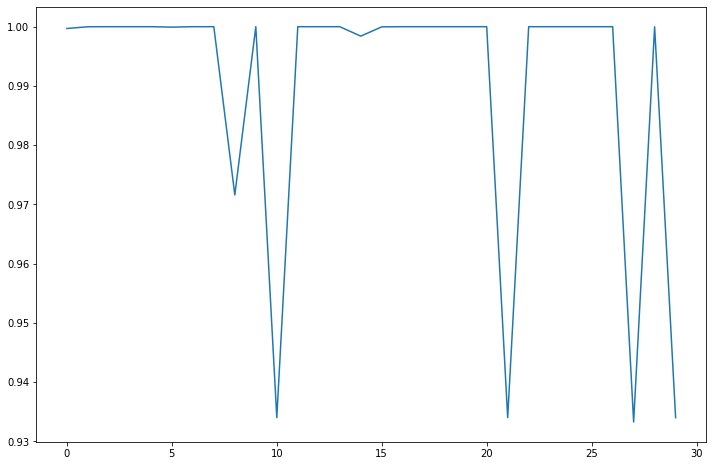

In [52]:
custos = []
solucao = []
dominio = [(0, 1)]

#Objetivo true para maximizar e false para minimizar
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo, dominio, True)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

exibir_sumario_resultados(solucao, custos, max)


- Podemos observar que os algoritmos genéticos, como esperado, apresentam um ótimo resultado, conseguindo atingir o máximo global na maiorio dos casos, com uma média próximo a 1 em todas as execuções
- Claro que o desempenho do algoritmo genético também vai variar bastante dependendo dos parâmetros utilizados, algoritmos com um número maior de parâmetros geralmente são melhores para generalizar problemas complexos, apesar de ser necessário encontrar o melhor conjunto de parâmetros
- Existem algumas técnicas, geralmente por força bruta ou aleatorização, que nos permitem encontrar melhores parâmetros para se adaptar ao problema, inclusive os próprios algoritmos genéticos são usados muita das vezes para fazer a busca por melhores parâmetros em outros algoritmos como em redes neurais.
- Nesse caso não foi necessário muito esforço para buscar parâmtros defido à simplicidade do problema. Quanto maior a população inicial, maiores as chances de encontrarmos nosso máximo global, devido ao pequeno espaço de busca definido pelo domínio [0,1]

### Avaliação dos algoritmos
- Qual algoritmo teve os resultados melhores e os parâmetros e técnicas que foram aplicados para isso.

## Terceiro problema
- No terceiro problema nós devemos lidar com um problema de duas dimensões, otimizando uma formula matemática com a variável X e Y:

![title](image/formula2.png)

### Objetivo
- Minimizar o valor da formula matemática.

### Representação
- Os valores são definidos em um intervalo de [-5, 5]

In [30]:
def funcao_custo_2(valor):
    x = valor[0]
    y = valor[1]

    custo = (1-x)**2 + (100 * (y - x**2)**2)
    return custo

Valor que gerou melhor resultado: (0.9999885515541882, 0.9999819755995043)
Melhor custo: 2.505056167879445e-09
Média de custos: 0.17756101155683732
Desvio padrão: 0.23991926531926494


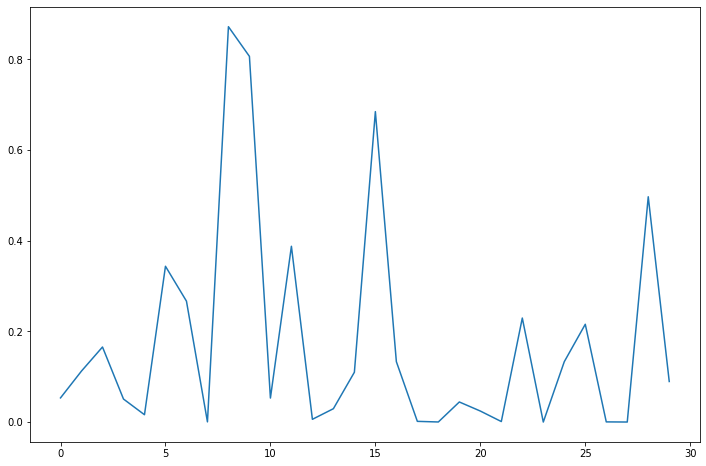

In [31]:
custos = []
solucao = []
dominio = [(-5, 5), (-5, 5)]

for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_2, dominio, False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

exibir_sumario_resultados(solucao, custos, min)

- O algoritmo genético conseguiu atingir bons resultados na maioria das vezes, chegando a valores muito próximos a 0.

## Primeiro problema
- Implementação dos algoritmos genéticos para ser capaz de reconhecer o número 0, usando apenas um vetor de números binários, onde o 1 é quando o pixel é branco e o zero ele é preto 
- Nesse problema, podemos definir um critério de parada a partir do objetivo, pois estamos satisfeitos assim que conseguirmos reconhecer o número 0, diferente dos demais problemas onde apenas tentamos executar até encontrar a melhor solução possível, que é desconhecida.

### Objetivo
- Ser capaz de reconhecer o valor 0
- **Minimizar** a diferença de binários do vetor atual em relação ao vetor correto (que repesenta o número 0)

### Representação
- vetor de binários, com 12 posições: 
- [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

### Nova função de custo
- Dessa vez, minha função de custo compara o vetor de exemplo (que é o número exato que eu quero detectar) com o vetor de entrada.
- A comparação me retorna um valor que diz respeito a quantos pixels existem de diferença entre o número que eu quero ser capaz de reconhecer e o número que foi passado, quando menor essa valor mais próximos estamos do nosso número de interesse.

In [32]:
def funcao_custo_3(vetor):
    numero_zero = [1, 1, 1, 1,0, 1, 1,0, 1, 1, 1, 1]
    custo = 0
    for i in range(len(vetor)):
        if vetor[i] != numero_zero[i]:
            custo += 1
    return custo

### Nova função de crossover
- Também fiz uma nova função para o crossover, permitindo o cruzamento em caso de um array de valores binários.
- Sorteamos um valor aleatório para dividir os cromossomos das duas soluções sorteadas (pais)
- Dividimos cada cromossomo baseado nesse número aleatório e o combinamos em uma nova solução filha

In [33]:
def crossover_binario(solucao1, solucao2):
    index_cruzamento = random.randint(0, len(solucao1) -1)
    solucao_resultante = solucao1[0:index_cruzamento] + solucao2[index_cruzamento:len(solucao2)]
    return solucao_resultante

### Nova função de mutação
- A função de mutação também fica diferente nesse caso, pois a mudança aplicada no gene do cromossomo não é mais uma subtração ou somatória por uma constante e sim uma mudança no valor binário.
- Essa mudança então é aplicada de forma aleatória em um dos genes do meu cromossomo

In [34]:
def mutacao_binaria(solucao):
    solucao = list(solucao)
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    gene_mutado = 1 if gene_mutado == 0 else 0
    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado)
    return tuple(solucao)

In [46]:
def genetico_2(funcao_custo, dominio, objetivo = False, tamanho_populacao = 12, p_mutacao = 0.2, 
               elitismo = 0.1, geracoes=8):
    
    populacao = get_populacao(tamanho_populacao, dominio, True)
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao - numero_elitismo) // 2, objetivo)
    
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(mutacao_binaria(individuos_escolhidos[individuo_selecionado]))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(crossover_binario(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
    return custos[0][0], custos[0][1]

In [47]:
custos = []
solucao = []
dominio = [(-5, 5), (-5, 5)]
dominio_3 = [(0, 1)] * 12

for i in range(30):
    solucao_algoritmo_genetico = genetico_2(funcao_custo_3, dominio_3, False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

### Melhor imagem obtida
- Abaixo podemos ver a melhor imagem que conseguimos chegar na execução do algoritmo
- Basta transformar nosso vetor em uma matrix 4x3 e plotar a imagem.

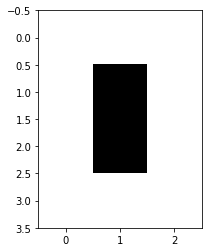

In [48]:
image = np.asmatrix(solucao[custos.index(min(custos))])
image = image.reshape(4, 3)
plt.imshow(image, cmap='gray')

Valor que gerou melhor resultado: (1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1)
Melhor custo: 0
Média de custos: 1.3333333333333333
Desvio padrão: 0.7453559924999298


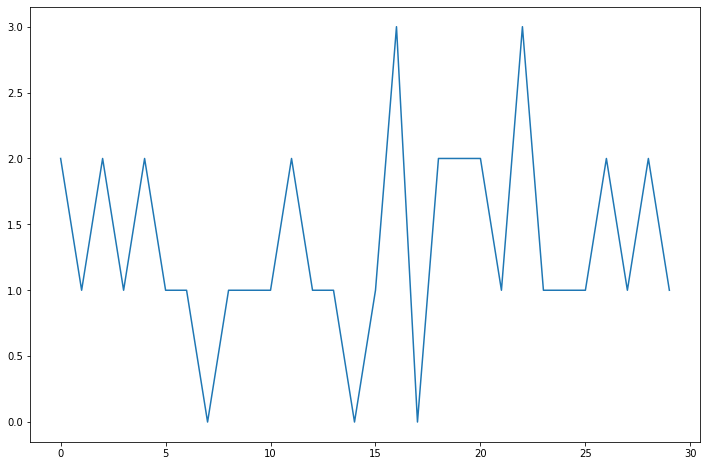

In [49]:
exibir_sumario_resultados(solucao, custos, min)

### Resultados e testes
- O algoritmo genético teve uma performance geral interessatne para detectar o padrão em questão.
- Os testes foram feitos usando diferentes parâmetros para observar o comportamento do algoritmo com um valor de 30 execuções para cada combinação de parâmetros.
- Ainda assim, cada vez que as 30 execuções acontecerem, ainda teremos resultados levemente diferentes, devido à aleatoriedade dos algoritmos de busca

- A ideia inicial foi gerar variações na população, mantendo 5 gerações apenas, os testes foram feitos com 8, 12, 16 e 20 indivíduos.
- Utilizar uma maior população irá nos fazer explorar uma área maior no espaço de busca, aumentando a chance de atingir bons resultados, porém com um tempo de convergência do algoritmo.
- Depois, variou - se a quantidade de gerações (5, 10, 15 e 20) mantendo a mesma população inicial de 8 indivíduos.
- As gerações são importantes para que os individuos consigam passar pela "evolução natural", sendo essencial para que o modelo convirja, porém com uma população muito pequena para o problema, corremos o risco de convergir para um ponto local ao invés do global.

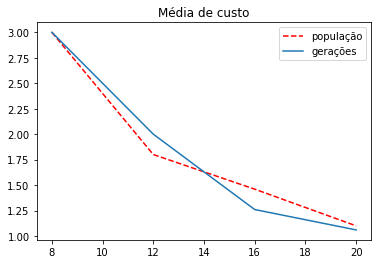

In [39]:
plt.plot([8, 12, 16, 20], [3, 1.8, 1.46, 1.1], 'r--', [8, 12, 16, 20], [3, 2, 1.26, 1.06])
plt.legend(['população', 'gerações'])
plt.title('Média de custo')
plt.show()

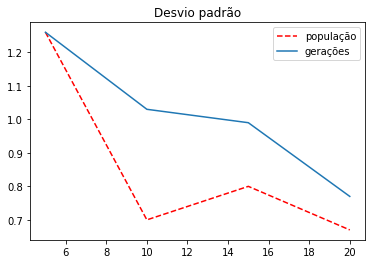

In [40]:
plt.plot([5, 10, 15, 20], [1.26, 0.7, 0.8, 0.67], 'r--', [5, 10, 15, 20], [1.26, 1.03, 0.99, 0.77])
plt.legend(['população', 'gerações'])
plt.title('Desvio padrão')
plt.show()

- Podemos observar uma diferença pequena na média de custos. Um ponto interessante, entretanto, é que aumentar a população sem aumentar as gerações nos gerou uma piora nos resultados, pois o algoritmo cria mais pontos no espaço mas não tem tempo de adaptá - los corretamente através da evolução.
- Todavia, é notável que o desvio padrão das tentativas com maior população é menor, pois como foi dito anteriormente, com mais indivíduos também temos uma chance maior de encontrar um bom ponto no nosso espaço de busca
- Portanto, como era de se esperar, o ideal é aumentar esses dois parâmetros de forma linear, pois uma maior exploração, nos exige também um maior tempo de convergência através da adaptação dos pontos nas gerações.

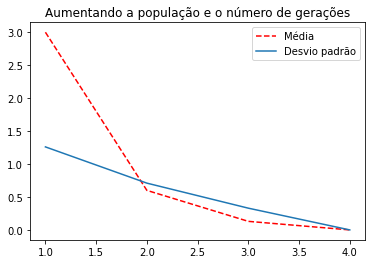

In [41]:
plt.plot([1, 2, 3, 4], [3, 0.6, 0.13, 0], 'r--', [1, 2, 3, 4], [1.26, 0.71, 0.33, 0])
plt.legend(['Média', 'Desvio padrão'])
plt.title('Aumentando a população e o número de gerações')
plt.show()

- Dessa vez a população e as gerações cresceram juntas: 8 e 5, 12 e 10, 16 e 15 e 20 e 20 respectivamente.
- Conseguimos atingir um ponto máximo de convergência na última execução com uma média e desvio de 0, sendo detectado o número 0 em todas as 30 execuções.